<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:


In [1]:
# !pip install pydotplus

In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker

import scipy.optimize as opt
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix, jaccard_score, f1_score, log_loss
from  io import StringIO
from PIL import *
import PIL.Image
import pydotplus
import seaborn as sns
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Lets download the dataset


In [3]:
# !wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

### Load Data From CSV File


In [4]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [5]:
df.shape

(346, 10)

### Convert to date time object


In [6]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [7]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Lets plot some columns to underestand data better:


In [8]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

In [9]:
#!pip install matplotlib==3.1.3

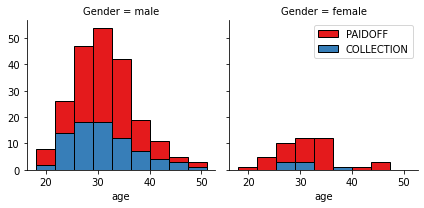

In [10]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

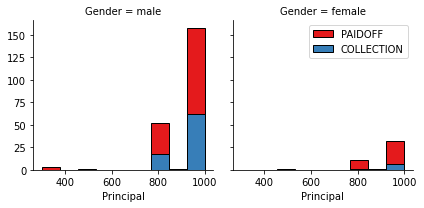

In [11]:
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Lets look at the day of the week people get the loan


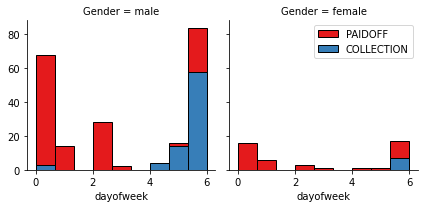

In [12]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4


In [13]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Lets look at gender:


In [14]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [15]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [16]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding


In [17]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [18]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection


Lets defind feature sets, X:


In [19]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [20]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split )


In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X = preprocessing.StandardScaler().fit(X).transform(X)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [24]:
Ks = 50
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.6       , 0.58571429, 0.75714286, 0.74285714, 0.7       ,
       0.74285714, 0.71428571, 0.58571429, 0.61428571, 0.61428571,
       0.61428571, 0.62857143, 0.65714286, 0.67142857, 0.71428571,
       0.74285714, 0.72857143, 0.72857143, 0.72857143, 0.71428571,
       0.71428571, 0.71428571, 0.72857143, 0.72857143, 0.72857143,
       0.71428571, 0.74285714, 0.7       , 0.72857143, 0.72857143,
       0.72857143, 0.71428571, 0.71428571, 0.71428571, 0.71428571,
       0.71428571, 0.72857143, 0.74285714, 0.72857143, 0.72857143,
       0.72857143, 0.72857143, 0.72857143, 0.72857143, 0.72857143,
       0.72857143, 0.75714286, 0.75714286, 0.75714286])

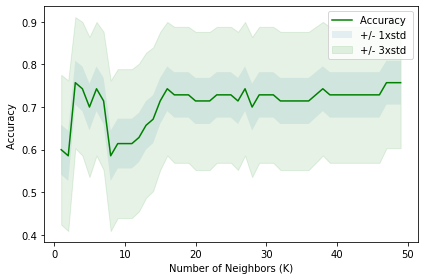

In [25]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10, color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [26]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax() + 1) 

The best accuracy was with 0.7571428571428571 with k= 3


In [27]:
# create a classifier with k specified above
k = mean_acc.argmax() + 1
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)

In [28]:
yhat = neigh.predict(X_test)
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.8369565217391305
Test set Accuracy:  0.7571428571428571


In [29]:
f1_score(y_test, yhat, average='weighted') 

0.7545980499251528

In [30]:
jaccard_score(y_test, yhat, average = "weighted")

0.6272534562211981

# Decision Tree


In [31]:
# create the model
decisionTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
# fit model on data
decisionTree.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [32]:
# predicted values
predTree = decisionTree.predict(X_test)

In [33]:
print (predTree [0:5])
print (y_test [0:5])

['PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


In [34]:
# evaluation
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree))

DecisionTrees's Accuracy:  0.5


In [35]:
Feature.columns

Index(['Principal', 'terms', 'age', 'Gender', 'weekend', 'Bechalor',
       'High School or Below', 'college'],
      dtype='object')

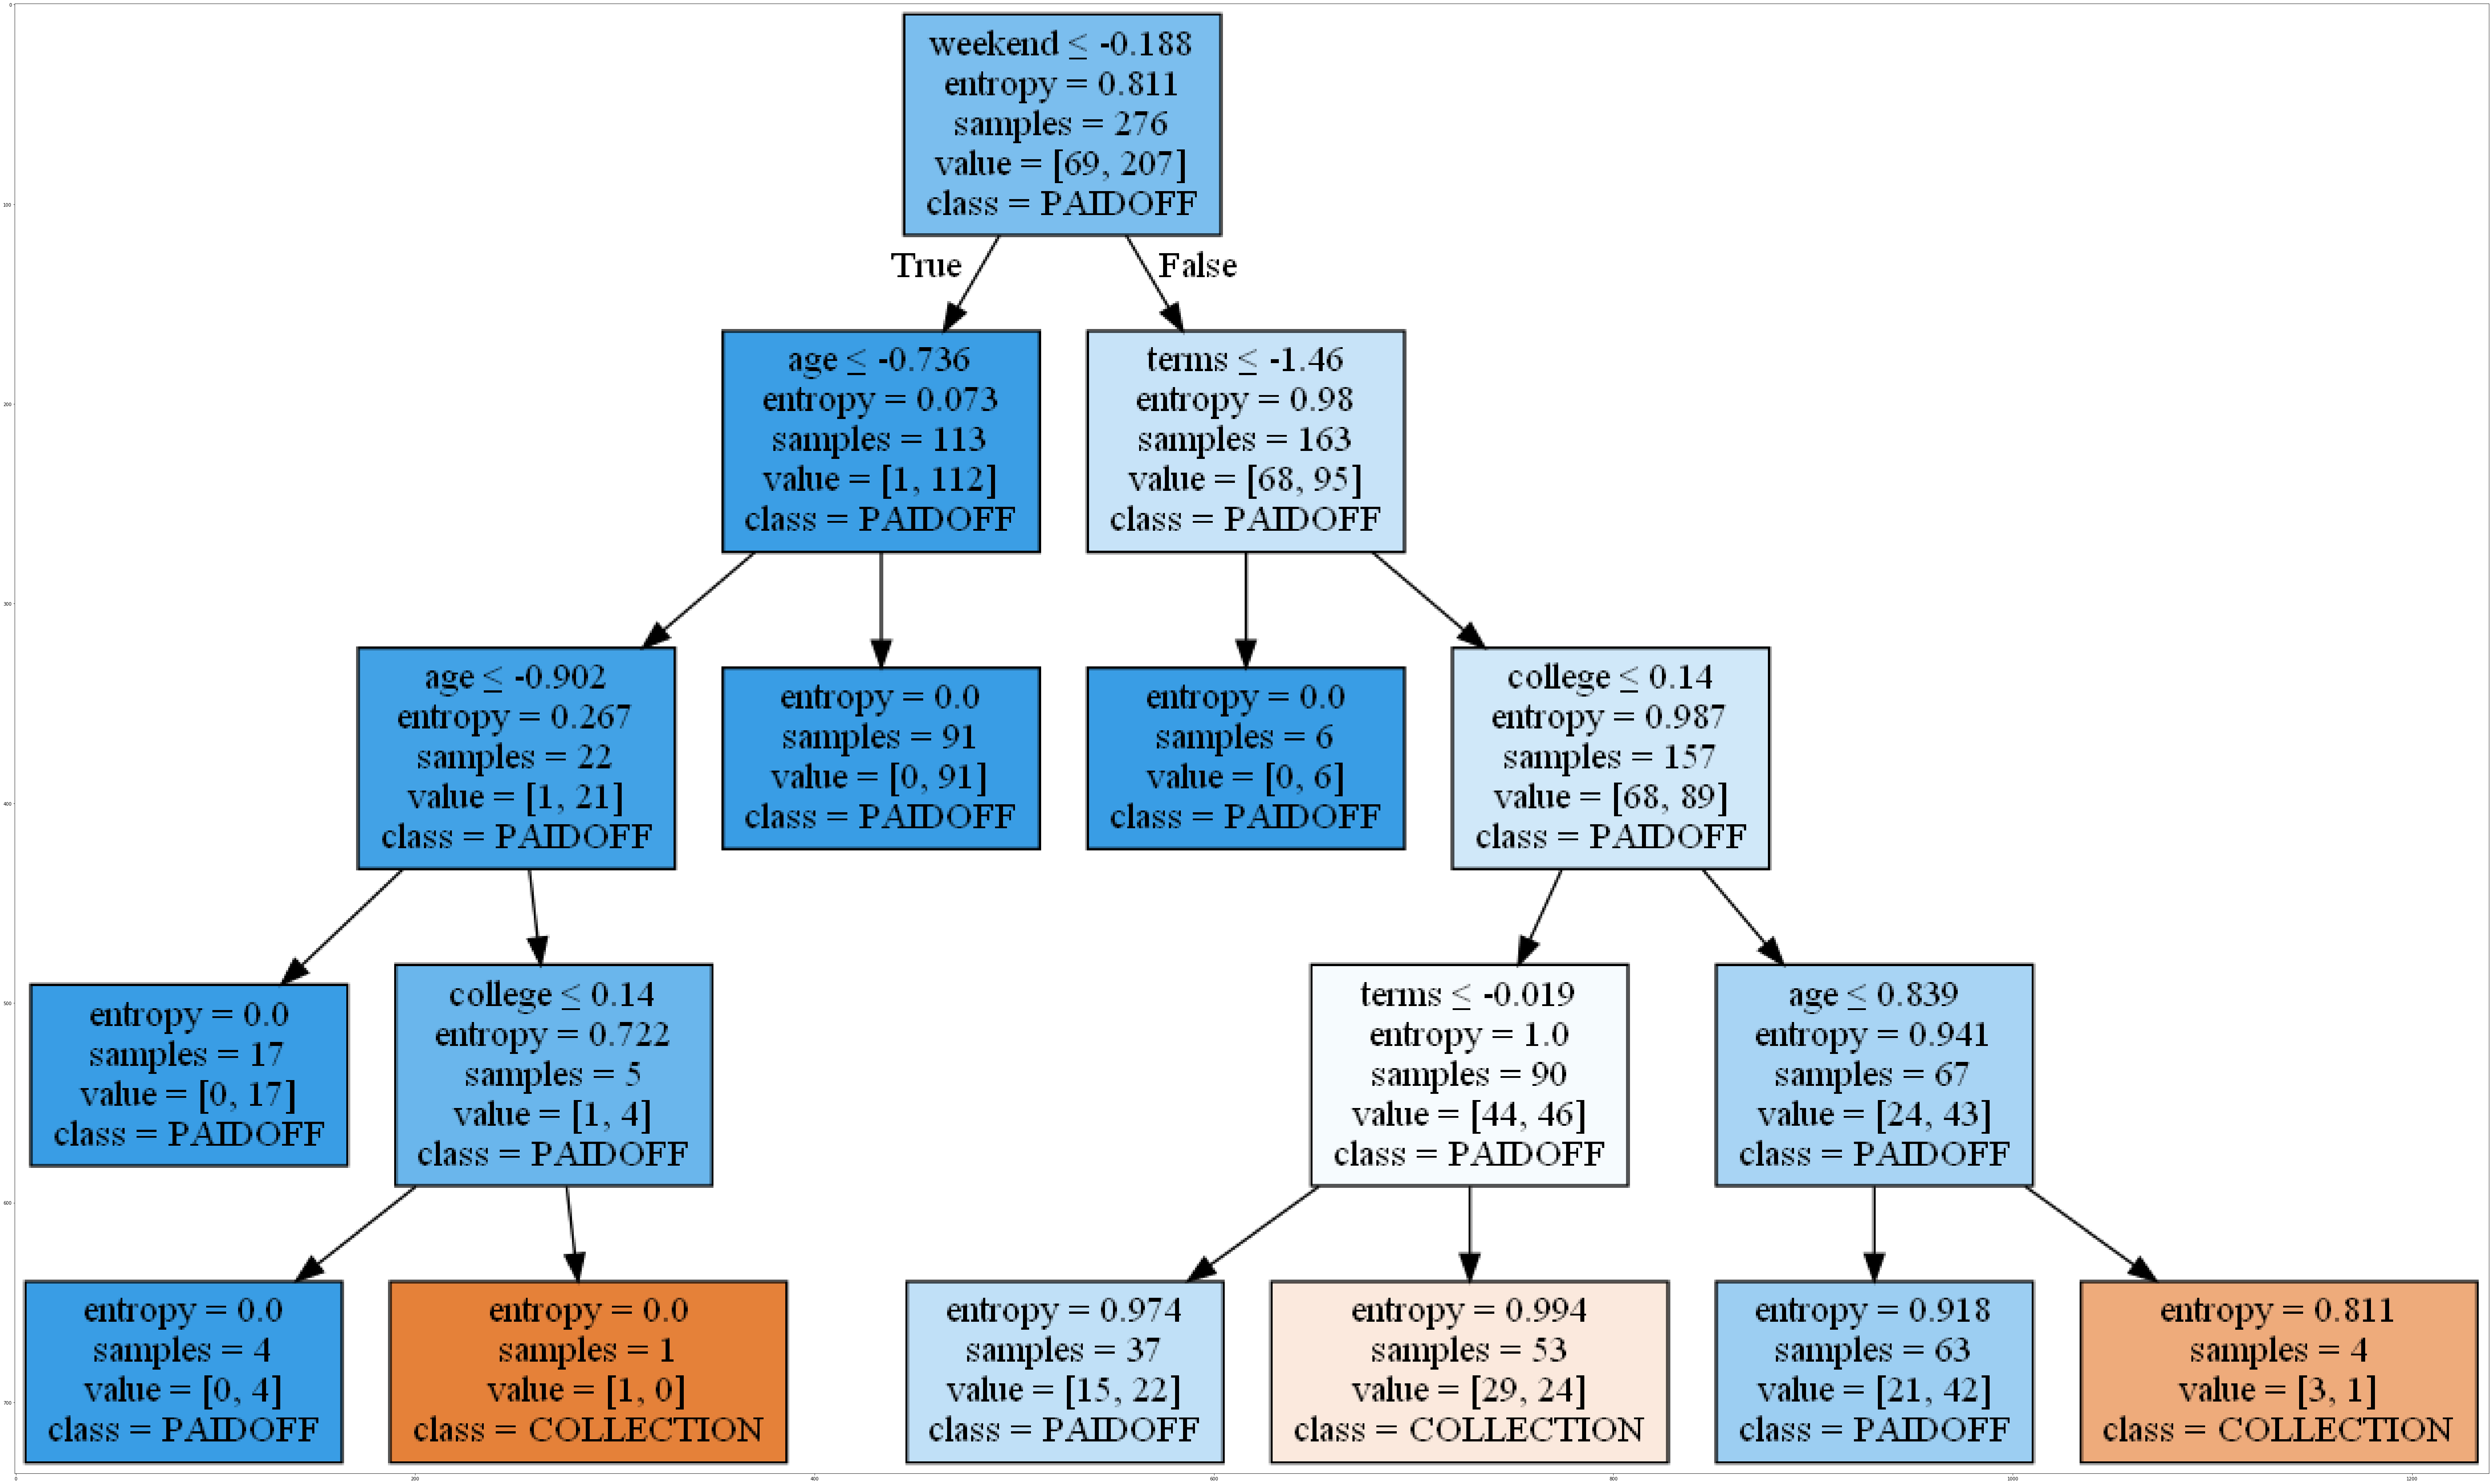

In [36]:
dot_data = StringIO()
filename = "paytree.png"
featureNames = Feature.columns[0:8]
out=tree.export_graphviz(decisionTree, \
                         feature_names = featureNames, \
                         out_file=dot_data, \
                         class_names = np.unique(y_train), \
                         filled = True,  \
                         special_characters = True, \
                         rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest');

# Support Vector Machine


In [37]:
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

SVC()

In [38]:
yhat_SVM = clf.predict(X_test)
yhat_SVM[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        17
     PAIDOFF       0.73      0.85      0.78        53

    accuracy                           0.64        70
   macro avg       0.36      0.42      0.39        70
weighted avg       0.55      0.64      0.59        70

Confusion matrix, without normalization
[[ 0 17]
 [ 8 45]]


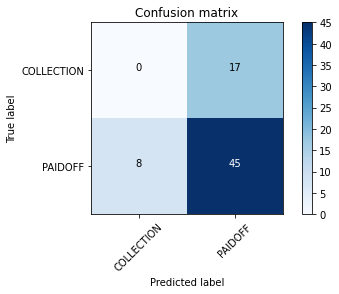

In [40]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_SVM)
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_SVM))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = ["COLLECTION", "PAIDOFF"], normalize= False,  title='Confusion matrix')

In [41]:
f1_score(y_test, yhat_SVM, average='weighted') 

0.5925465838509317

In [42]:
jaccard_score(y_test, yhat_SVM, average='weighted')

0.4867346938775511

# Logistic Regression


In [43]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)

In [44]:
yhat_LR = LR.predict(X_test)
yhat_LR

array(['PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF'], dtype=object)

In [45]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.5 , 0.5 ],
       [0.5 , 0.5 ],
       [0.5 , 0.5 ],
       [0.3 , 0.7 ],
       [0.3 , 0.7 ],
       [0.5 , 0.5 ],
       [0.34, 0.66],
       [0.45, 0.55],
       [0.53, 0.47],
       [0.49, 0.51],
       [0.28, 0.72],
       [0.5 , 0.5 ],
       [0.27, 0.73],
       [0.25, 0.75],
       [0.49, 0.51],
       [0.49, 0.51],
       [0.5 , 0.5 ],
       [0.49, 0.51],
       [0.5 , 0.5 ],
       [0.33, 0.67],
       [0.51, 0.49],
       [0.48, 0.52],
       [0.34, 0.66],
       [0.3 , 0.7 ],
       [0.27, 0.73],
       [0.5 , 0.5 ],
       [0.31, 0.69],
       [0.5 , 0.5 ],
       [0.27, 0.73],
       [0.49, 0.51],
       [0.51, 0.49],
       [0.29, 0.71],
       [0.3 , 0.7 ],
       [0.54, 0.46],
       [0.46, 0.54],
       [0.5 , 0.5 ],
       [0.33, 0.67],
       [0.51, 0.49],
       [0.28, 0.72],
       [0.34, 0.66],
       [0.51, 0.49],
       [0.44, 0.56],
       [0.5 , 0.5 ],
       [0.33, 0.67],
       [0.5 , 0.5 ],
       [0.48, 0.52],
       [0.49, 0.51],
       [0.35,

In [46]:
jaccard_score(y_test, yhat, average = "weighted")

0.6272534562211981

In [47]:
f1_score(y_test, yhat, average='weighted') 

0.7545980499251528

In [48]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    


In [49]:
print(confusion_matrix(y_test, yhat_LR))

[[ 2 15]
 [ 9 44]]


In [50]:
print (classification_report(y_test, yhat_LR, zero_division = 0))

              precision    recall  f1-score   support

  COLLECTION       0.18      0.12      0.14        17
     PAIDOFF       0.75      0.83      0.79        53

    accuracy                           0.66        70
   macro avg       0.46      0.47      0.46        70
weighted avg       0.61      0.66      0.63        70



Confusion matrix, without normalization
[[ 2 15]
 [ 9 44]]


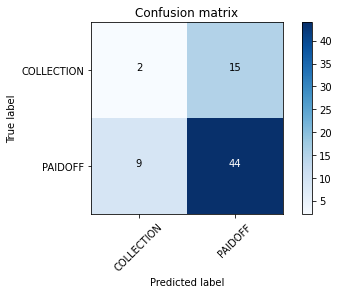

In [51]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_LR)
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = ["COLLECTION", "PAIDOFF"], normalize= False,  title='Confusion matrix')

In [52]:
log_loss(y_test, yhat_prob)

0.5904073878189214

# Model Evaluation using Test set


First, download and load the test set:


In [53]:
#!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

### Load Test set for evaluation


In [54]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [55]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

In [56]:
test_df['loan_status'].value_counts()

PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64

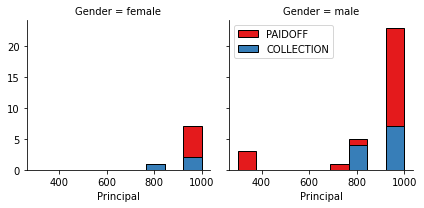

In [57]:
bins = np.linspace(test_df.Principal.min(), test_df.Principal.max(), 10)
g = sns.FacetGrid(test_df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

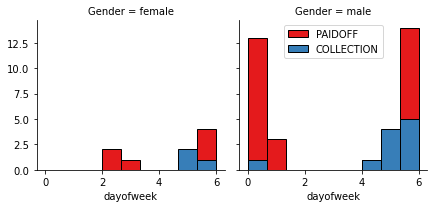

In [58]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
bins = np.linspace(test_df.dayofweek.min(), test_df.dayofweek.max(), 10)
g = sns.FacetGrid(test_df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

In [59]:
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,1


In [60]:
test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.727273
        COLLECTION     0.272727
male    PAIDOFF        0.744186
        COLLECTION     0.255814
Name: loan_status, dtype: float64

In [61]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [62]:
test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        1.000000
High School or Below  PAIDOFF        0.523810
                      COLLECTION     0.476190
Master or Above       PAIDOFF        1.000000
college               PAIDOFF        0.826087
                      COLLECTION     0.173913
Name: loan_status, dtype: float64

In [63]:
test_df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,50,1,Bechalor
1,300,7,35,0,Master or Above
2,1000,30,43,1,High School or Below
3,1000,30,26,0,college
4,800,15,29,0,Bechalor


In [64]:
Feature = test_df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [65]:
X_test = Feature
X_test[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [66]:
y_test = test_df['loan_status'].values
y_test[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [67]:
X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)

# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


In [68]:
KNN_yhat = neigh.predict(X_test)
Tree_yhat = decisionTree.predict(X_test)
SVM_yhat = clf.predict(X_test)
LR_yhat = LR.predict(X_test)
LR_yhat_prob = LR.predict_proba(X_test)

In [69]:
scores = {
"KNN":[jaccard_score(y_test, Tree_yhat, average='weighted').round(2), \
       f1_score(y_test, Tree_yhat, average='weighted').round(2), np.nan],
"Decision Tree": [jaccard_score(y_test, Tree_yhat, average='weighted').round(2),\
                  f1_score(y_test, Tree_yhat, average='weighted').round(2), np.nan],
"SVM": [jaccard_score(y_test, SVM_yhat, average='weighted').round(2), \
        f1_score(y_test, SVM_yhat, average='weighted').round(2), np.nan],
"Logistic Regression": [jaccard_score(y_test, LR_yhat, average='weighted').round(2), \
                        f1_score(y_test, LR_yhat, average='weighted').round(2), log_loss(y_test, LR_yhat_prob).round(2)]
}

In [70]:
print("KNN Jaccard score: %.4f" % jaccard_score(y_test, KNN_yhat, average='weighted'))
print("KNN F1-score: %.4f" % f1_score(y_test, KNN_yhat, average='weighted'))

print("Decision Tree Jaccard score: %.4f" % jaccard_score(y_test, Tree_yhat, average='weighted'))
print("Decision Tree F1-score: %.4f" % f1_score(y_test, Tree_yhat, average='weighted'))

print("SVM Jaccard score: %.4f" % jaccard_score(y_test, SVM_yhat, average='weighted'))
print("SVM F1-score: %.4f" % f1_score(y_test, SVM_yhat, average='weighted'))

print("Logistic Regression Jaccard score: %.4f" % jaccard_score(y_test, LR_yhat, average='weighted'))
print("Logistic Regression F1-score: %.4f" % f1_score(y_test, LR_yhat, average='weighted'))
print("Logistic Regression LogLoss: %.4f" % log_loss(y_test, LR_yhat_prob))

KNN Jaccard score: 0.4711
KNN F1-score: 0.6154
Decision Tree Jaccard score: 0.6025
Decision Tree F1-score: 0.7339
SVM Jaccard score: 0.5493
SVM F1-score: 0.6736
Logistic Regression Jaccard score: 0.6005
Logistic Regression F1-score: 0.7144
Logistic Regression LogLoss: 0.5742


In [71]:
pd.DataFrame.from_dict(scores, orient = "index", columns = ["Jaccard", "F1-Score", "LogLoss"])

,Jaccard,F1-Score,LogLoss
KNN,0.60,0.73,NaN
Decision Tree,0.60,0.73,NaN
SVM,0.55,0.67,NaN
Logistic Regression,0.60,0.71,0.57


| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.0000  |0.0000    | NA      |
| Decision Tree      | 0.0000  |0.0000    | NA      |
| SVM                | 0.0000  |0.0000    | NA      |
| LogisticRegression | 0.0000  |0.0000    | 0.0000  |


In [72]:
from sklearn.ensemble import GradientBoostingClassifier

In [73]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train)

In [74]:
clf_yhat = clf.predict(X_test)
clf_yhat

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF'], dtype=object)

In [75]:
clf.score(X_test, y_test)

0.6666666666666666

In [76]:
print("XGboost Jaccard score: %.4f" % jaccard_score(y_test, clf_yhat, average='weighted'))
print("XGboost Tree F1-score: %.4f" % f1_score(y_test, clf_yhat, average='weighted'))

XGboost Jaccard score: 0.5250
XGboost Tree F1-score: 0.6667


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By | Change Description |
|---|---|---|---|
| 2020-10-27 | 2.1 | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27 | 2.0 | Malika Singla | Added lab to GitLab |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
